In [1]:
# Computations
import numpy as np
import pandas as pd

# scipy
import scipy.stats as stats
from scipy.stats import norm

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import re

# sklearn
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.utils.fixes import loguniform

from sklearn.ensemble import RandomForestClassifier

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## missingno
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
Telco Customer Churn
</b></font>
</div>


In this article, we analyze and predict customer churn for [Telco Customer Churn data](https://www.kaggle.com/blastchar/telco-customer-churn).

### Dataset

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device * protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

| Columns     | Description     |
|------------------    |---------------------------------------------------------------------------------------------------------------------------------    |
| customerID     | Customer ID     |
| gender     | Whether the customer is a male or a female     |
| SeniorCitizen     | Whether the customer is a senior citizen or not (1, 0)     |
| Partner     | Whether the customer has a partner or not (Yes, No)     |
| Dependents     | Whether the customer has dependents or not (Yes, No)     |
| tenure     | Number of months the customer has stayed with the company     |
| PhoneService     | Whether the customer has a phone service or not (Yes, No)     |
| MultipleLines     | Whether the customer has multiple lines or not (Yes, No, No phone service)     |
| InternetService     | Customer’s internet service provider (DSL, Fiber optic, No)     |
| OnlineSecurity     | Whether the customer has online security or not (Yes, No, No internet service)     |
| OnlineBackup     | Whether the customer has an online backup or not (Yes, No, No internet service)     |
| DeviceProtection     | Whether the customer has device protection or not (Yes, No, No internet service)     |
| TechSupport     | Whether the customer has tech support or not (Yes, No, No internet service)     |
| StreamingTV     | Whether the customer has streaming TV or not (Yes, No, No internet service)     |
| StreamingMovies     | Whether the customer has streaming movies or not (Yes, No, No internet service)     |
| Contract     | The contract term of the customer (Month-to-month, One year, Two years)     |
| PaperlessBilling     | Whether the customer has paperless billing or not (Yes, No)     |
| PaymentMethod     | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))     |
| MonthlyCharges     | The amount charged to the customer monthly     |
| TotalCharges     | The total amount charged to the customer     |
| Churn     | Whether the customer churned or not (Yes or No)     |

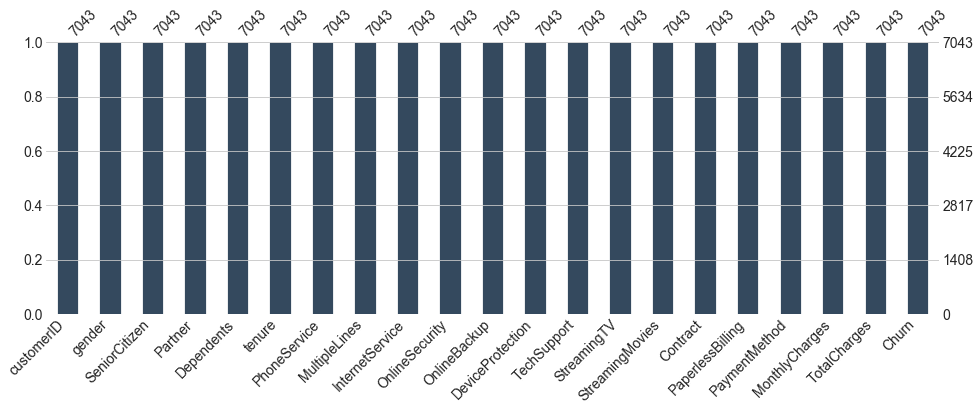

In [2]:
Data = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

def Data_info(Inp, Only_NaN = False):
    Out = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = Out.join(Inp.isnull().sum().to_frame(name = 'Number of NaN Values'), how='outer')
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out

def dtypes_group(Inp):
    Temp = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = pd.DataFrame(index =Temp['Data Type'].unique(), columns = ['Columns'])
    for c in Temp['Data Type'].unique():
        Out.loc[Out.index == c, 'Columns'] = [Temp.loc[Temp['Data Type'] == c].index.tolist()]
    return Out

_ = msno.bar(Data, figsize=(16,5), fontsize=14, log=False, color="#34495e")

def text_sep(txt): return re.sub(r"(\w)([A-Z])", r"\1 \2", txt)

def col_details(Col):
    print(Back.BLACK + Fore.CYAN + Style.NORMAL + '%s:' % text_sep(Col) +
          Style.RESET_ALL + ' %s' % ', '.join(Data[Col].unique()))
    
Data.rename(columns = {'gender':'Gender', 'tenure':'Tenure'}, inplace = True)
Data.columns = [text_sep(txt) for txt in Data.columns.tolist()]

# Preprocessing

## Int Columns

In [3]:
Data_types = dtypes_group(Data)
display(Data_types)
Temp = Data_types.loc[Data_types.index == 'int64'].values[0,0]
Data[Temp] = Data[Temp].astype(int)
del Temp

Columns
int64                             [Senior Citizen, Tenure]
float64                                  [Monthly Charges]
object   [customer ID, Payment Method, Paperless Billin...

## Float Columns

In [4]:
Temp = Data_types.loc[Data_types.index == 'float64'].values[0,0]
Data[Temp] = Data[Temp].astype(float)
del Temp
Data['Total Charges'] = pd.to_numeric(Data['Total Charges'], errors='coerce')

## Yes/No Columns

First, let's convert all Yes/No columns using as follows

\begin{cases} 0 &\mbox{No}\\ 1 &\mbox{Yes}\end{cases}

In [5]:
Temp = []
for i in Data_types.loc[Data_types.index == 'object'].values[0,0]:
    if set(Data[i].unique().tolist()) == {'No', 'Yes'}:
        Temp.append(i)
        
Data[Temp] = Data[Temp].replace({'Yes':1, 'No':0}).astype(int)
del Temp

However, some other columns can be converted similarly; however, we need to create a new feature.

In [6]:
Temp = []
for i in Data_types.loc[Data_types.index == 'object'].values[0,0]:
    if set(Data[i].unique().tolist()) == {'No', 'No internet service', 'Yes'}:
        Temp.append(i)
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Columns:' +
          Style.RESET_ALL + ' %s' % ', '.join(Temp))

Columns: Streaming Movies, Streaming TV, Tech Support, Device Protection, Online Backup, Online Security


Note that,

In [7]:
col_details('Internet Service')

Internet Service: DSL, Fiber optic, No


This Column can be coded as follows

$$\mbox{InternetServiceType} = \begin{cases} 0 &\mbox{No} \\ 1 &\mbox{DSL}\\ 2 &\mbox{Fiber optic}\end{cases}$$

In [8]:
def myfun(x):
    if x == 'No':
        return 0
    elif x == 'DSL':
        return 1
    else:
        return 2

Data['Internet Service'] = Data['Internet Service'].apply(lambda x: myfun(x)).astype(int)
del myfun

Since we have already included **No interent service** in **InternetService**, we can code the rest as,

\begin{cases} 0 &\mbox{No, No internet service}\\ 1 &\mbox{Yes}\end{cases}

In [9]:
Data[Temp] = Data[Temp].applymap(lambda x: 1 if x =='Yes' else 0).astype(int)

Since, there is already a feature as **PhoneService**, for **MultipleLines**, we can try
$$
\mbox{MultipleLines} = \begin{cases} 0 &\mbox{No, No phone service}\\ 1 &\mbox{Yes}\end{cases}
$$

In [10]:
Data['Multiple Lines'] = Data['Multiple Lines'].map(lambda x: 1 if x =='Yes' else 0).astype(int)

## Other Columns

In [11]:
Data_types = dtypes_group(Data)
Temp = Data_types.loc[Data_types.index == 'object'].values[0,0]
print('Columns: %s' %', '.join(Temp))

Columns: Contract, Gender, Payment Method, customer ID


### Contract

In [12]:
col_details('Contract')

Contract: Month-to-month, One year, Two year


\begin{cases} 0 &\mbox{Month-to-month}\\ 1 &\mbox{One year}\\ 2 &\mbox{Two year} \end{cases}

In [13]:
Data['Contract'] = Data['Contract'].replace({'Month-to-month':0, 'One year':1, 'Two year':2}).astype(int)

### Gender

$$
\mbox{Gender} = \begin{cases} 0 &\mbox{Female}\\ 1 &\mbox{Male}\end{cases}
$$

In [14]:
Data['Gender'] = Data['Gender'].map(lambda x: 1 if x =='Male' else 0).astype(int)

### PaymentMethod

In [15]:
col_details('Payment Method')

Payment Method: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)


In this case, we can not rank these values. Therefore,

In [16]:
Data = Data.join(pd.get_dummies(Data['Payment Method']).astype(int))
Data = Data.drop(columns = ['Payment Method'])
Data_types = dtypes_group(Data)
display(Data_types)

Columns
int32    [Device Protection, Credit card (automatic), B...
float64                   [Monthly Charges, Total Charges]
object                                       [customer ID]

## Imputing Missing Values

In [17]:
Temp = Data_info(Data, Only_NaN = True)
Temp = Temp.index.tolist()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
Data[Temp] = imp.fit_transform(Data[Temp])

## Data Correlations

Let's take a look at the variance of the features.

In [18]:
display(Data.drop(columns = ['Churn']).var().sort_values(ascending = False).to_frame(name= 'Variance')\
       .style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)).set_precision(2))

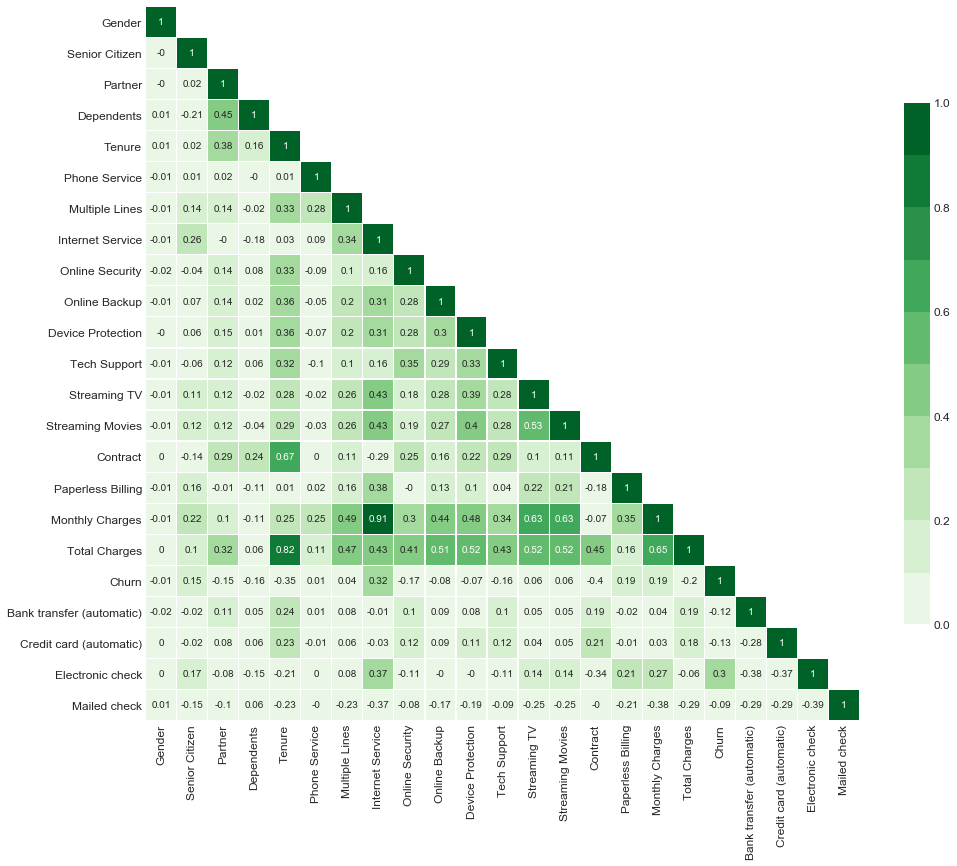

In [19]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("Greens", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .6})

Correlation_Plot (Data, 16)

Correlations of features with customer **Churn**.

In [20]:
Temp = Data.corr().round(2)
Temp['Churn'].sort_values().to_frame(name= 'Correlation')[:-1].style.background_gradient(cmap='RdYlGn',
                                                                                 subset=['Correlation']).set_precision(2)

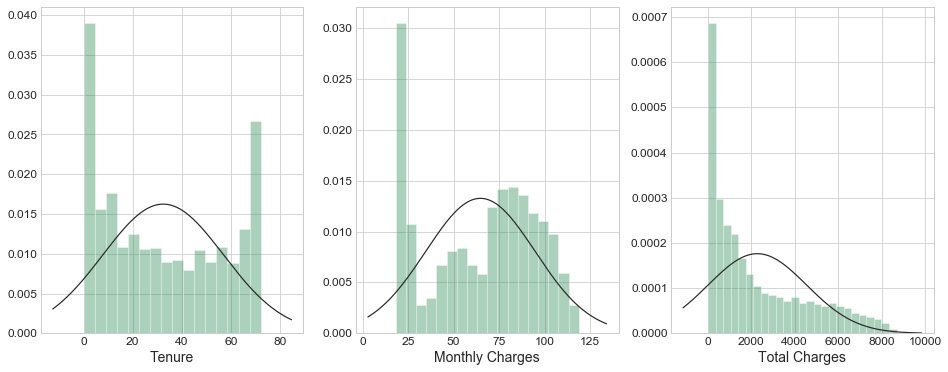

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16, 6))
Temp = ['Tenure','Monthly Charges','Total Charges']

for i in range(len(Temp)):
    _ = sns.distplot(Data[Temp[i]], 
                     fit=norm, kde=False, color='seagreen', ax= ax[i])

# Modeling

In [22]:
df = Data.drop(columns = ['customer ID'])
Target = 'Churn'
X = df.drop(columns = [Target])
y = df[Target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T
Labels = ['Remanined', 'Churned']

Furthermore, we would like to standardize features by removing the mean and scaling to unit variance. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification.html), we demonstrated the benefits of scaling data using [**StandardScaler()**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [23]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(data = X_train, columns = X.columns)
X_test = pd.DataFrame(data = X_test, columns = X.columns)

A number of functions that we would use.

In [24]:
def Performance(clf, X_test = X_test):
    df = pd.DataFrame()
    y_pred = clf.predict(X_test)
    df = df.append({'Score': clf.score(X_test, y_test),
                    'F1 Score': f1_score(y_test.values, y_pred, average= 'weighted'),
                    'Precision Score': precision_score(y_test.values, y_pred, average= 'weighted'),
                    'Recall Score':  recall_score(y_test.values, y_pred, average= 'weighted')}, ignore_index=True)
    display(df.style.hide_index())

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: SpringGreen' if v else '' for v in is_max]


def Feature_Ranking(clf):
    df = pd.DataFrame()
    for n in range(2, X.shape[1]):
        selector = RFE(estimator= clf, n_features_to_select=n, verbose=0)
        selector.fit(X_train, y_train)
        df = df.append({'Number of Features to Select': n,
                        'Score':metrics.accuracy_score(y_test, selector.predict(X_test)),
                        'Features': X.columns[selector.support_].tolist(),
                        'Best Features':X.columns[selector.ranking_ == 1].tolist()}, ignore_index=True)

    df = df[['Number of Features to Select', 'Score', 'Features', 'Best Features']]
    display(df.style.apply(highlight_max, subset=['Score']))
    return df.loc[df.Score == df.Score.max(), 'Features'].values[0]

def ROC_Curve(clf, X_test = X_test):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([0,1])
    # _ = ax.set_ylim([0,1])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')

For this set of data, we would like to implement Random Forest Classifier. which creates a set of decision trees from a randomly selected subset of the training set. It benefits from voting of different decision trees for classifying the final outputs.

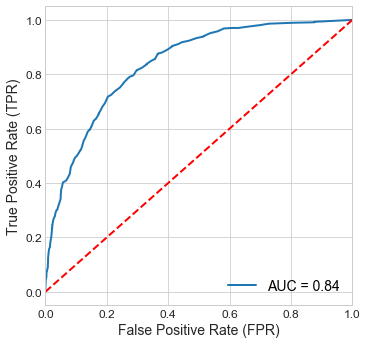

In [25]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train,y_train)
Performance(rfc)
ROC_Curve(rfc)

However, we only need to implement features that are useful for classifications. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification_Feature_Importance.html), we demonstrated the importance of feature ranking.

In [26]:
Best_Features = Feature_Ranking(rfc)

Thus, the best features:

In [27]:
print(Best_Features)

['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']


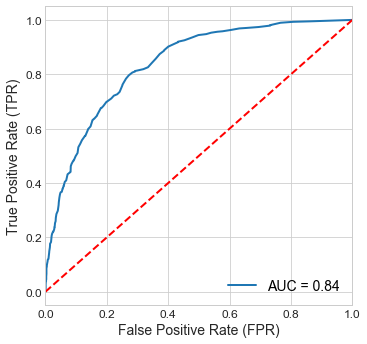

In [28]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train[Best_Features],y_train)
Performance(rfc, X_test[Best_Features])
ROC_Curve(rfc, X_test[Best_Features])

The main classification metrics:

In [29]:
pd.DataFrame(classification_report(y_test,rfc.predict(X_test[Best_Features]),
                                   output_dict = True, target_names = Labels))

Remanined     Churned  accuracy    macro avg  weighted avg
precision     0.820453    0.676020  0.793658     0.748237      0.781218
recall        0.917479    0.461672  0.793658     0.689576      0.793658
f1-score      0.866258    0.548654  0.793658     0.707456      0.779980
support    1539.000000  574.000000  0.793658  2113.000000   2113.000000

A confusion matrix allows the visualization of the performance of a classification model.

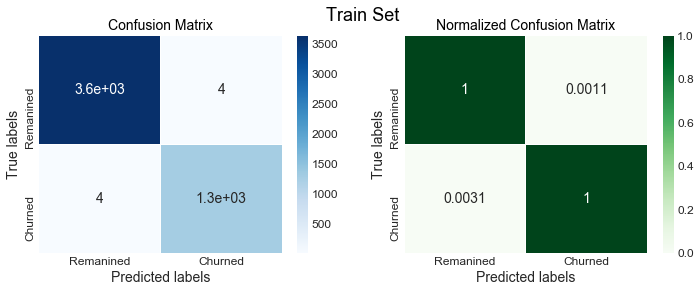

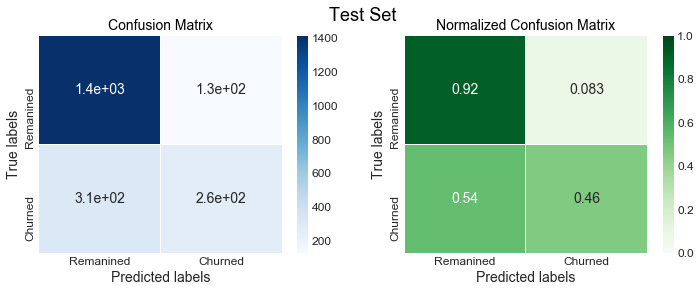

In [30]:
# Train set
y_pred = rfc.predict(X_train[Best_Features])
Confusion_Matrix = confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = rfc.predict(X_test[Best_Features])
Confusion_Matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Final Thoughts

Finally, customer churn can be predicted using our model for the test data.

In [31]:
display(pd.DataFrame(list(rfc.predict_proba(X_test[Best_Features].values)), columns= Labels))

Remanined  Churned
0          0.40     0.60
1          0.90     0.10
2          1.00     0.00
3          0.38     0.62
4          0.98     0.02
...         ...      ...
2108       0.09     0.91
2109       0.51     0.49
2110       0.96     0.04
2111       0.69     0.31
2112       0.77     0.23

[2113 rows x 2 columns]

***